*italicized text*# Deep learning for hyperspectral image processing: 2-D convolutional neural networks
This notebook demonstrates application of 2-Dimensional Convolutional Neural Network (2-D CNN) models to land use classification. Unlike Multi-Layer Perceptron [(MLP)](deep_learning_MLP.ipynb) models, where each pixel is considered as an input vector, the 2-D CNN models also utilize the spatial information of the neighboring pixels. A separate notebook is also available, describing the application of 3-Dimenaional Convolutional neural networks to landuse classification[(3-D CNN)](deep_learning_3D_CNN.ipynb).

## Module imports
Below is the list of libraries and modules that are required in this notebook. The 'keras' package provides the building blocks for model configuration and training. The 'img_util' contains a set of useful functions for pre-processing of raw data to create input and output data containers, compatible to the 'keras' package. In addition, it provides a set of functions for post-processing of results and visualization of prediction maps.
The 'sio' and 'os' module were used for working with external files. The plotting of data and generation of prediction maps were achieved using plotting functionalities of 'matplotlib'.  

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# import sys
# sys.path.append('/kaggle/input/util-py')


import numpy as np
from keras import models, layers, optimizers, metrics, losses, regularizers
import img_util as util
from scipy import io as sio
import os
from matplotlib import pyplot as plt
import tensorflow

2024-07-12 14:01:01.483563: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-12 14:01:01.535950: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-12 14:01:02.274725: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# New Section

## Hyperspectral dataset
A set of publically-available hyperspectral imageray datasets can be downloaded form [this](http://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes) website. The Indian Pine dataset was downloaded and used in this notebook. The dataset consists of 150$\times$150 pixels with 200 refelactance bands. The ground truth data for the dataset consists of 16 different classes. A summary of landuse types and their corresponding number of samples can be found in the following table:

| ID       | Class                        | Samples |
|----------|------------------------------|---------|
| 0        | Unlabeled                    | 10776   |
| 1        | Alfalfa                      | 46      |
| 2        | Corn-notill                  | 1428    |
| 3        | Corn-mintill                 | 830     |
| 4        | Corn                         | 237     |
| 5        | Grass-pasture                | 483     |
| 6        | Grass-trees                  | 730     |
| 7        | Grass-pasture-mowed          | 28      |
| 8        | Hay-windrowed                | 478     |
| 9        | Oats                         | 20      |
| 10       | Soybean-notill               | 972     |
| 11       | Soybean-mintill              | 2455    |
| 12       | Soybean-clean                | 593     |
| 13       | Wheat                        | 205     |
| 14       | Woods                        | 1265    |
| 15       | Buildings-Grass-Trees-Drives | 386     |
| 16       | Stone-Steel-Towers           | 93      |

The image data and class labels are available in two separate Matlab files with .mat extension. Therefore, the data were loaded into Python using the 'loadmat' function, available in the 'io' module of Scipy.

In [3]:
data_folder = './'
data_file= 'combinedbands_salinas'
gt_file = 'Salinas_gt'
#original
# data_set = sio.loadmat(os.path.join(data_folder, data_file)).get('paviaU')
# gt = sio.loadmat(os.path.join(data_folder, gt_file)).get('paviaU_gt')
# partitioned based IP
# data_set = sio.loadmat(os.path.join(data_folder, data_file)).get('indian_pines_corrected')
# gt = sio.loadmat(os.path.join(data_folder, gt_file)).get('indian_pines_gt')
#partitioned based SA
data_set = sio.loadmat(os.path.join(data_folder, data_file)).get('combinedbands')
gt = sio.loadmat(os.path.join(data_folder, gt_file)).get('salinas_gt')
#KSC
#data_set = sio.loadmat(os.path.join(data_folder, data_file)).get('KSC')
#gt = sio.loadmat(os.path.join(data_folder, gt_file)).get('KSC_gt')
#data_set = sio.loadmat(os.path.join(data_folder, data_file)).get('Botswana')
#gt = sio.loadmat(os.path.join(data_folder, gt_file)).get('Botswana_gt')
# Checking the shape of data_set (containing image data) and gt (containing ground truth data) Numpy arrays.
print(data_set.shape ,gt.shape)

(512, 217, 42) (512, 217)


## Training and test data
The 'data_split' function was used for splitting the data into training and test sets using 0.75 as the split ratio (75% of labeled pixels were used for training). This function ensures that all classes are represented in the training dataset (see function documentation for available split methods). In addition, it allows users to focus their analysis on certain classes and remove those pixels that are not labeled. For example, the unlabeled data are represented by 0 in the gourd truth data file. Therefore, 0 was included in 'rem_classes' list, indicating its removal from the dataset.

In [4]:
train_fraction = 0.75
rem_classes = [0]
(train_rows, train_cols), (test_rows, test_cols) = util.data_split(gt,
                                                                   train_fraction=train_fraction,
                                                                   rem_classes=rem_classes)

print('Number of training samples = {}.\nNumber of test samples = {}.'.format(len(train_rows), len(test_rows)))

Number of training samples = 40591.
Number of test samples = 13536.


A portion of training data can optionally be set aside for validation.

In [5]:
val_fraction = 0.05
(train_rows_sub, train_cols_sub), (val_rows, val_cols) = util.val_split(
        train_rows, train_cols, gt, val_fraction=val_fraction)

## Dimensionality reduction
The spectral dimension of an image dataset can be reduced using Principle Component Analysis (PCA). Although, this step is not necessary, it could significantly reduce the spectral dimension without losing important information. The 'reduce_dim' function takes the numpy array containing image data as its first argument and the number of reduced dimensions (i.e., an integer) or the minimum variance captured by PCA dimensions (i.e., a float) as the second argument.   

In [6]:
# data_set = util.reduce_dim(img_data=data_set, n_components=.999)
data_set = util.reduce_dim(img_data=data_set, n_components=3)
data_set.shape


(512, 217, 3)

Using a value of 0.999 for the percentage of captured variance, the spectral dimension was reduced from 200 to 69 bands. The new dimensions were sorted according to their contribution to the dataset variance. The top 10 dimensions of transformed data are illustrated below.

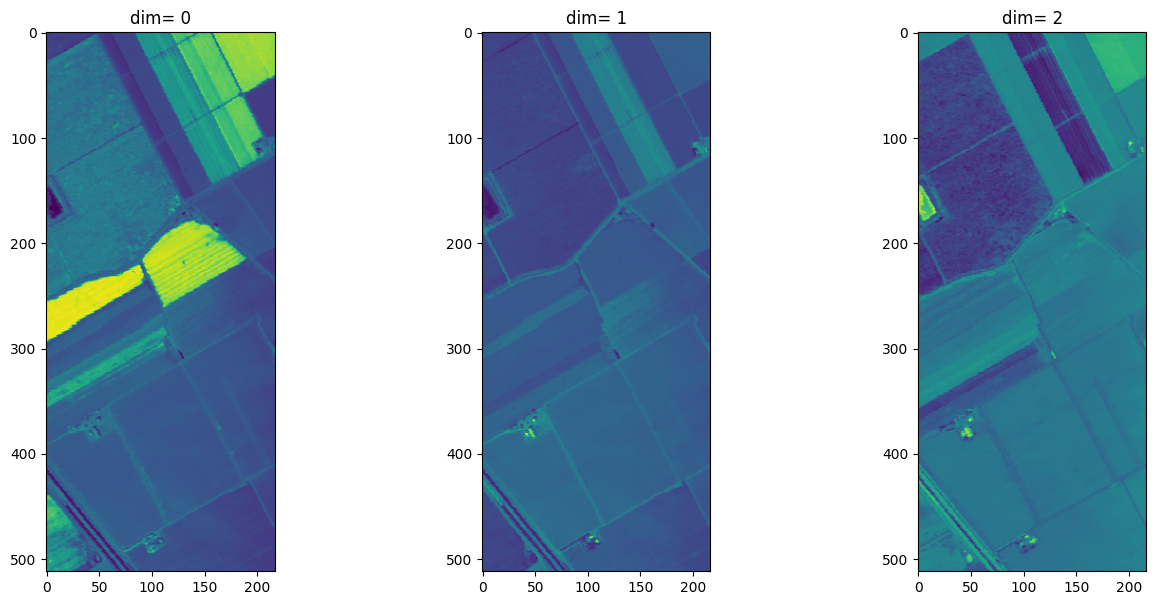

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 7))
for numb, axe in enumerate(axes):
    axe.imshow(data_set[:, :, numb])
    axe.set_title('dim=' + ' ' + str(numb))
plt.subplots_adjust(wspace=0.5)
plt.show()


## Rescaling data
The 'rescale_data' function provides four methods for rescaling data at each spectral dimension. In this notebook, the 'standard' method which transforms the data to have zero mean and a standard deviation of 1 was used for rescaling data.

In [8]:
data_set = util.rescale_data(data_set)

In [9]:
data_set.shape

(512, 217, 3)

## Creating input and target tensors
The input and target tensors should be compatible with the type of neural network model that is used for classification. The 'create_patch' function can create inputs, compatible to both pixel inputs for [MLP](deep_learning_MLP.ipynb) models as well as patch inputs for [2-D CNN](deep_learning_2D_CNN.ipynb) and [3-D CNN](deep_learning_3D_CNN.ipynb) models.
In this notebook, a 2-D CNN model with a 'path_size' of 5 is used for classification.  

In [10]:
patch_size = 64
train_pixel_indices_sub = (train_rows_sub, train_cols_sub)
val_pixel_indices = (val_rows, val_cols)
test_pixel_indices = (test_rows, test_cols)
catg_labels = np.unique([int(gt[idx[0],idx[1]]) for idx in zip(train_rows, train_cols)])
int_to_vector_dict = util.label_2_one_hot(catg_labels)

train_input_sub, y_train_sub = util.create_patch(
    data_set=data_set,
    gt=gt,
    pixel_indices=train_pixel_indices_sub,
    patch_size=patch_size,
    label_vect_dict=int_to_vector_dict)

print("Train Input Sub Size:", train_input_sub.shape)

val_input, y_val = util.create_patch(
    data_set=data_set,
    gt=gt,
    pixel_indices=val_pixel_indices,
    patch_size=patch_size,
    label_vect_dict=int_to_vector_dict)

print("Validation Input Size:", val_input.shape)

test_input, y_test = util.create_patch(
    data_set=data_set,
    gt=gt,
    pixel_indices=test_pixel_indices,
    patch_size=patch_size,
    label_vect_dict=int_to_vector_dict)

print("Test Input Size:", test_input.shape)


Train Input Sub Size: (38551, 64, 64, 3)
Validation Input Size: (2039, 64, 64, 3)
Test Input Size: (13536, 64, 64, 3)


## Creating a MobileNetV2 Model

In [11]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Average
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Define the input layer with the desired shape
desired_input_shape = (64, 64, 3)
input_layer = Input(shape=desired_input_shape)

# Load MobileNetV2 pre-trained on ImageNet data but without the top classification layer
base_model_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_layer)

# Freeze the layers of the base_model
for layer in base_model_mobilenet.layers:
    layer.trainable = False

# Add custom layers on top of MobileNetV2
x = base_model_mobilenet.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions_mobilenet = Dense(16, activation='softmax')(x)

# This is the model we will train
mobilenet_model = Model(inputs=base_model_mobilenet.input, outputs=predictions_mobilenet)


/tmp/ipykernel_111196/3058861268.py:12: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_layer)
2024-07-12 14:09:12.315034: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [12]:
from tensorflow.keras.applications import ResNet50

# Load ResNet50 pre-trained on ImageNet data but without the top classification layer
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_tensor=input_layer)

# Freeze the layers of the base_model
for layer in base_model_resnet.layers:
    layer.trainable = False

# Add custom layers on top of ResNet50
x = base_model_resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
predictions_resnet = Dense(16, activation='softmax')(x)

# This is the model we will train
resnet_model = Model(inputs=base_model_resnet.input, outputs=predictions_resnet)


In [13]:
# Define the function to create the ensemble model
def ensemble(models, model_input):
    outputs = [model(model_input) for model in models]
    y = Average()(outputs)
    model = Model(model_input, y, name='ensemble')
    return model

# Create the ensemble model
ensemble_model = ensemble([resnet_model, mobilenet_model], input_layer)

# Compile the ensemble model
ensemble_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# View the structure of the ensemble model
ensemble_model.summary()


Model: "ensemble"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_3        │ (None, 16)        │ 24,803,088 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 16)        │  3,049,296 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average (Average)   │ (None, 16)        │          0 │ functional_3[0][… │
│                     │                   │            │ functional_1[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 27,852,384 (106.25 MB)

 Trainable params: 2,006,688 (7.65 MB)

 Non-trainable params: 25,845,696 (98.59 MB)

In [14]:
!pip install adam

Defaulting to user installation because normal site-packages is not writeable


In [15]:
from tensorflow.keras.optimizers import Adam

## Training model and plotting training history
The model was compiled and trained using the training, validation and test [data.](#Creating-input-and-target-tensors)

Epoch 1/20
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 99s 82ms/step - accuracy: 0.9983 - loss: 0.0307 - val_accuracy: 0.9990 - val_loss: 0.0299
Epoch 2/20
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 98s 82ms/step - accuracy: 0.9987 - loss: 0.0295 - val_accuracy: 0.9995 - val_loss: 0.0286
Epoch 3/20
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 99s 82ms/step - accuracy: 0.9989 - loss: 0.0305 - val_accuracy: 0.9995 - val_loss: 0.0273
Epoch 4/20
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 99s 82ms/step - accuracy: 0.9987 - loss: 0.0306 - val_accuracy: 0.9995 - val_loss: 0.0275
Epoch 5/20
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 99s 82ms/step - accuracy: 0.9985 - loss: 0.0306 - val_accuracy: 0.9990 - val_loss: 0.0278
Epoch 6/20
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 99s 82ms/step - accuracy: 0.9983 - loss: 0.0282 - val_accuracy: 0.9985 - val_loss: 0.0286
Epoch 7/20
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 99s 82ms/step - accuracy: 0.9986 - loss: 0.0293 - val_accuracy: 0.9990 - val_loss: 0.0287
Epoch 8/20
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 99s 83ms/step - accuracy: 0.9983 -

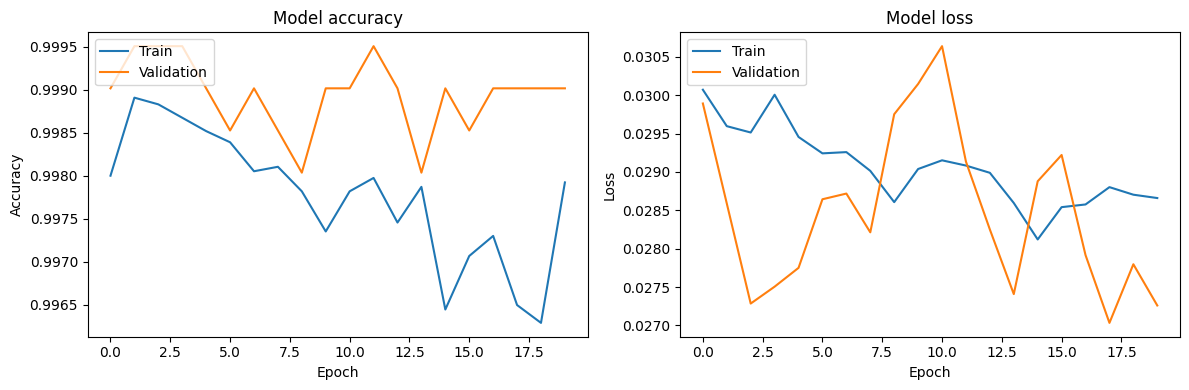

In [17]:

# from tensorflow.keras.models import load_model


# model_path = 'Ensemble_Salinas.keras'

# if os.path.exists(model_path):
#     # Load the existing model
#     ensemble_model = load_model(model_path)
#     print("Model loaded from disk.")
# else:
#     # Ensure train_input_sub, y_train_sub, val_input, and y_val are defined
#     # Assuming they are already defined as per your dataset

#     # Compile and train the ensemble model
history = ensemble_model.fit(
    x=train_input_sub,
    y=y_train_sub,
    batch_size=32,
    epochs=20,
    validation_data=(val_input, y_val),
    verbose=True
)

# # Save the model
# ensemble_model.save('model_Salinas.h5')
# print("Model trained and saved to disk.")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


## Model performance evaluation
Overall loss and accuracy of the model was calculated using the 'evaluate' method. The loss and accuracy for each class was also calculated using the 'calc_metrics' function of the 'img_util' module.  

In [18]:
overall_loss, overal_accu = ensemble_model.evaluate(test_input, y_test, verbose=False)
print('Overall loss = {}'.format(overall_loss))
print('Overall accuracy = {}\n'.format(overal_accu))

# Calculating accuracy for each class
ensemble_model_metrics = util.calc_metrics(ensemble_model, test_input,y_test, int_to_vector_dict, verbose=False)

#Printing accuracy per class
print('{}{:>13}\n{}'.format('Class ID','Accuracy', 30*'_'))
for key, val in ensemble_model_metrics.items():
    print(('{:>2d}{:>18.4f}\n'+'{}').format(key, val[0][1], 30*'_'))

Overall loss = 0.02710256725549698
Overall accuracy = 0.9978575706481934

Class ID     Accuracy
______________________________
 1            1.0000
______________________________
 2            1.0000
______________________________
 3            0.9433
______________________________
 4            1.0000
______________________________
 5            0.9985
______________________________
 6            1.0000
______________________________
 7            1.0000
______________________________
 8            1.0000
______________________________
 9            1.0000
______________________________
10            1.0000
______________________________
11            1.0000
______________________________
12            1.0000
______________________________
13            1.0000
______________________________
14            1.0000
______________________________
15            1.0000
______________________________
16            1.0000
______________________________


In [19]:
# calculate Kappa coefficient
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
Y_pred = ensemble_model.predict(train_input_sub)
y_pred = np.argmax(Y_pred, axis=1)
kappa = cohen_kappa_score(np.argmax(y_train_sub, axis=1), y_pred)
kappa

1205/1205 ━━━━━━━━━━━━━━━━━━━━ 94s 76ms/step


0.997660166181147

## Making predictions using using test data
The trained model was used for label predictions using the training, validation, and test datasets. It was also used to make label prediction for the entire dataset including unlabeled pixels.

54126/54126 ━━━━━━━━━━━━━━━━━━━━ 1299s 24ms/step


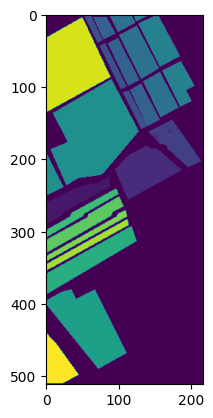

In [20]:
# Plotting predicted results
concat_rows =  np.concatenate((train_rows_sub, val_rows, test_rows))
concat_cols = np.concatenate((train_cols_sub, val_cols, test_cols))
concat_input = np.concatenate((train_input_sub, val_input, test_input))
concat_y = np.concatenate((y_train_sub, y_val, y_test))
pixel_indices = (concat_rows, concat_cols)

partial_map = util.plot_partial_map(ensemble_model, gt, pixel_indices, concat_input,
                            concat_y, int_to_vector_dict, plo=False)
plt.imshow(partial_map)


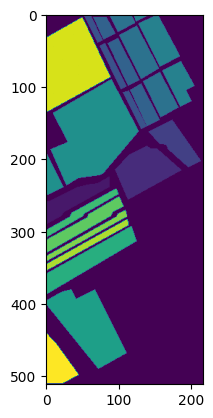

In [21]:
plt.imshow(gt)

In [23]:
import os
from tensorflow import keras

# Define the model save path
model_save_path = 'ensemble_model_Salinas.keras'

# Remove the existing file if it exists
if os.path.exists(model_save_path):
    os.remove(model_save_path)

# Save the trained ensemble model in the recommended Keras format
ensemble_model.save(model_save_path)
print(f"Model trained and saved to {model_save_path}.")

# Load the saved model
loaded_model = keras.models.load_model(model_save_path)
print("Model loaded from disk.")


Model trained and saved to ensemble_model_Salinas.keras.
Model loaded from disk.


/home/jupyter-25001/.local/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 384 variables whereas the saved optimizer has 30 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
